### Model devlopment
#### TCN (Temporal Convolution Neural Network)

In [9]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.models import TCNModel

# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

In [2]:
# Data preparation for model development

df =pd.read_csv('final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# split the data into train and validation
train, validation = my_multivariate_series.split_after(0.8)

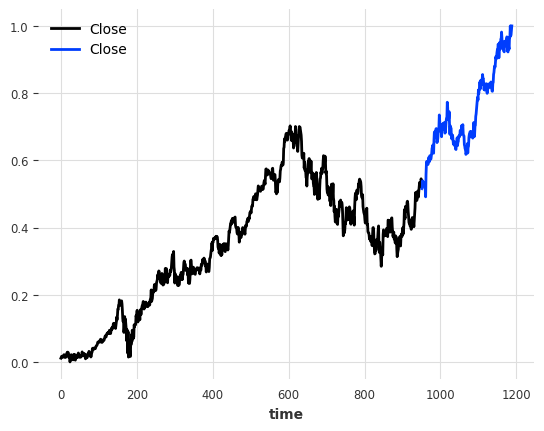

In [3]:
train['Close'].plot()
validation['Close'].plot()

In [4]:
# define the covarients using train and validation data

past_cov_train_vol = train['Volume']
past_cov_val_vol = validation['Volume']

past_cov_train_fn = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val_fn = validation[['Volume', 'EPS', 'P/E', 'P/S']]

In [5]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.02,
    mode='min',
)
pl_trainer_kwargs={"callbacks": [my_stopper]}

### Hyper parameter define


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 164   
----------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.04
R2 = 0.87
MAPE = 4.20


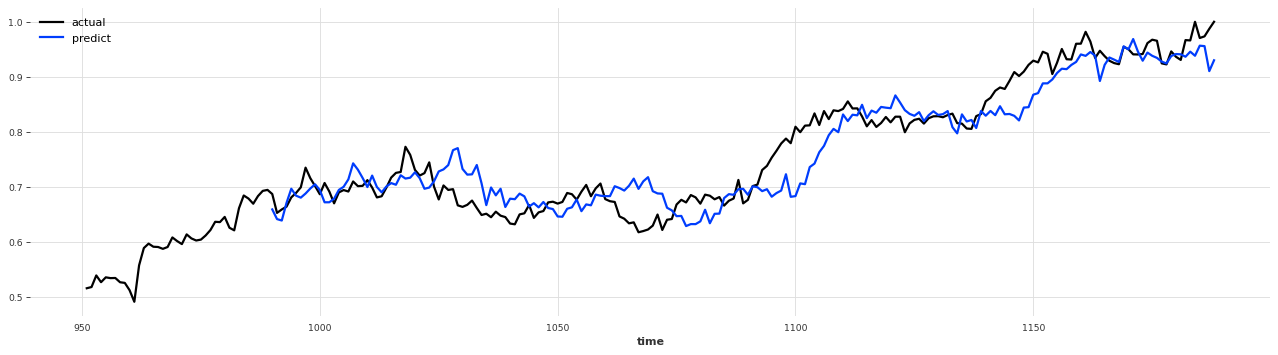

In [12]:
TCN_par1 = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3,
    n_epochs=50, dropout=0.01,
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
TCN_par1.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train_vol, past_cov_val_vol])

pred_par1 = TCN_par1.predict(
    series=validation['Close'],
    past_covariates=past_cov_val_vol,
    n=10)
pred_par1_pris = scaler.inverse_transform(pred_par1)
pred_par1_pris.values()

TCN_par1_pred_series = TCN_par1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False,
)

TCN_par1_rmse = rmse(validation['Close'], TCN_par1_pred_series)
TCN_par1_r2 = r2_score(validation['Close'], TCN_par1_pred_series)
TCN_par1_mape = mape(validation['Close'], TCN_par1_pred_series)
print("RMSE = %.2f" % TCN_par1_rmse)
print("R2 = %.2f" % TCN_par1_r2)
print("MAPE = %.2f" % TCN_par1_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
TCN_par1_pred_series.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 200   
----------------------------------------------------
200       Trainable params
0         Non-trainable params
200       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.04
R2 = 0.86
MAPE = 4.29


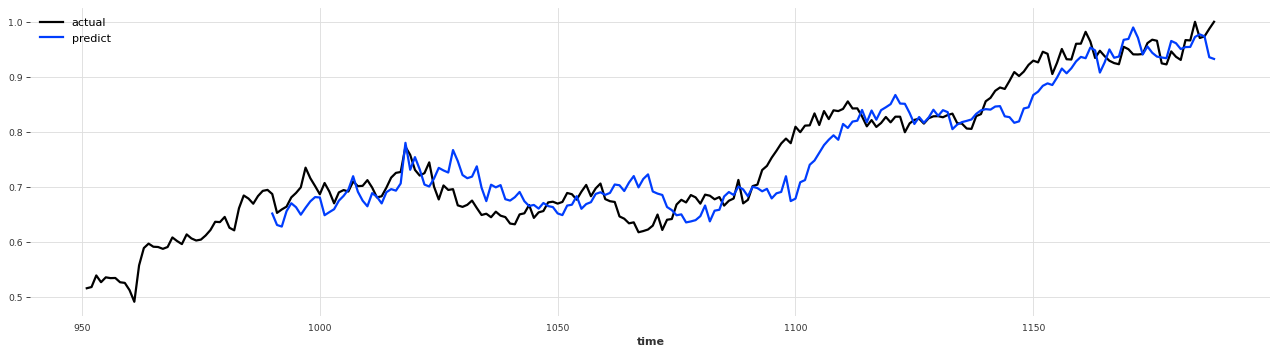

In [14]:
TCN_par1_fn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3,
    n_epochs=50, dropout=0.01,
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
TCN_par1_fn.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train_fn, past_cov_val_fn])

pred_par1_fn = TCN_par1_fn.predict(
    series=validation['Close'],
    past_covariates=past_cov_val_fn,
    n=10)
pred_par1_fn_pris = scaler.inverse_transform(pred_par1_fn)
pred_par1_fn_pris.values()

TCN_par1_fn_pred_series = TCN_par1_fn.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)

TCN_par1_fn_rmse = rmse(validation['Close'], TCN_par1_fn_pred_series)
TCN_par1_fn_r2 = r2_score(validation['Close'], TCN_par1_fn_pred_series)
TCN_par1_fn_mape = mape(validation['Close'], TCN_par1_fn_pred_series)
print("RMSE = %.2f" % TCN_par1_fn_rmse)
print("R2 = %.2f" % TCN_par1_fn_r2)
print("MAPE = %.2f" % TCN_par1_fn_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
TCN_par1_fn_pred_series.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 200   
----------------------------------------------------
200       Trainable params
0         Non-trainable params
200       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 0.04
R2 = 0.88
MAPE = 3.94


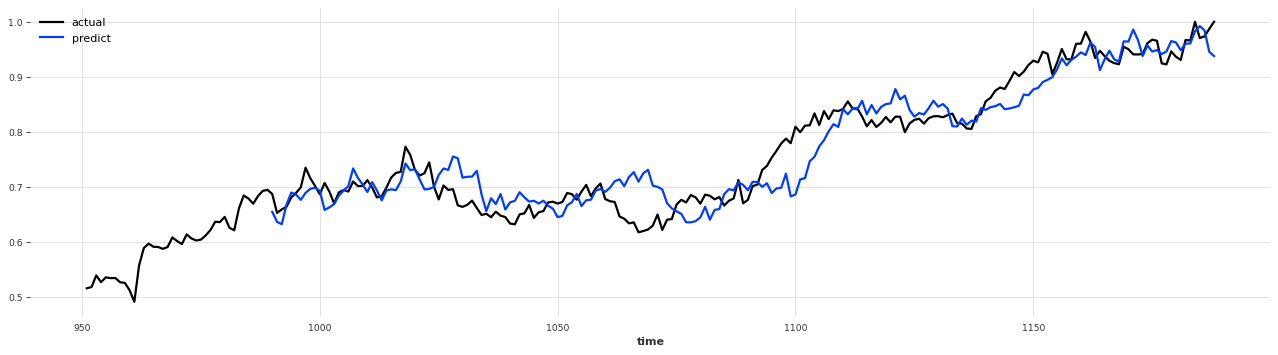

In [15]:
TCN_par1_fn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=3, num_filters=3, num_layers=3,
    n_epochs=100, dropout=0.005,
    #pl_trainer_kwargs={"callbacks": [my_stopper]}
)
TCN_par1_fn.fit([train['Close'], validation['Close']], past_covariates=[past_cov_train_fn, past_cov_val_fn])

pred_par1_fn = TCN_par1_fn.predict(
    series=validation['Close'],
    past_covariates=past_cov_val_fn,
    n=10)
pred_par1_fn_pris = scaler.inverse_transform(pred_par1_fn)
pred_par1_fn_pris.values()

TCN_par1_fn_pred_series = TCN_par1_fn.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False,
)

TCN_par1_fn_rmse = rmse(validation['Close'], TCN_par1_fn_pred_series)
TCN_par1_fn_r2 = r2_score(validation['Close'], TCN_par1_fn_pred_series)
TCN_par1_fn_mape = mape(validation['Close'], TCN_par1_fn_pred_series)
print("RMSE = %.2f" % TCN_par1_fn_rmse)
print("R2 = %.2f" % TCN_par1_fn_r2)
print("MAPE = %.2f" % TCN_par1_fn_mape)

plt.figure(figsize=(20, 5), dpi=80)
validation['Close'].plot(label="actual")
TCN_par1_fn_pred_series.plot(label="predict")
plt.show()